## Uczenie Nienadzorowane - projekt
- Sebastian Borukało (259188)
- Jakub Bukała (259189)
- Jakub Smakowski (259209)

Celem projektu jest zbudowanie modelu uzupełniającego (inpainting) uszkodzenia dzieł sztuki pochodzącyzh z platformy WikiArt w oparciu o metody uczenia nienadzorowanego (unsupervised) i samonadzorowanego (self-supervised) należy zbudować system pozwalający na grupowanie obrazów na podstawie ich podobieństwa oraz uzupełnianie ich symulowanych uszkodzeń.

1. Budowę systemu należy rozpocząć od budowy generatora uszkodzeń obrazów (białych plam /masek). Podstawowa wersja uszkadzania obrazów polega na losowym wycinaniu / maskowaniu kwadratowych fragmentów obrazu, zajmujących nie więcej niż 1/16 obrazu. Rozszerzona wersja powinna pozwalać na generowanie uszkodzeń o nieregularnych kształtach.
2. Kolejnym krokiem powinno być zbudowanie zredukowanej reprezentacji obrazów ze zbioru treningowego a następnie jej klasteryzacji w celu znalezienia naturalnego grupowania styli. Grupowanie należy następnie porównać z dostępnymi w zbiorze etykietami stylu i autora.
3. Następnie, dla każdej z grup należy nauczyć osobny model uzupełniający uszkodzenia. Alternatywnie, możliwe jest zbudowanie jednego modelu który na wejściu przyjmowałby uszkodzony obraz oraz identyfikator grupy.
4. Końcowym etapem będzie zbudowanie modelu zwiększającego rozdzielczość obrazów

# ETAP I: Inpainter
Celem tego kroku projektu jest prezentacja modelu InPainter opartego na architekturze U-Net. Nasz model wykorzystuje również informacje o klasie obrazu którą otrzymujemy poprzez analizę wyekstrahowanych cech omówionych dokładniej w etapie 2. Dzięki temu nie musieliśmy trenować osobnych modeli do każdej z klas a jeden wspólny.

**Wykorzystane technologie:**  
- Model: U-Net (z multigłowiem wewnątrz bloków przetwarzających)
- Dane: WikiArt (Obrazy artystyczne).  
- Środowisko: Lokalne (trenowane na RTX 3060 12GB)
- Śledzenie eksperymentów: Comet ML / własne logi i checkpointy

**Opis modelu:**
Model InPainter V5 realizuje proces w kilku krokach:
1. **Encoder - ekstrakcja:** Pierwsza część ekstrahuje cechy do skondensowanego tensora (256x256x3 --> 16x16x160)
2. **Redukcja cech:** Warstwa redukuje tensor 16x16x160 do wymiaru 1x1x160 za pomocą global_avg_pooling (efektywnie jest to teraz wektor cech 160)
3. **Klasteryzacja:** Przypisujemy do klasy za pomocą wytrenowanego klasteryzatora (własnie na tych cechach. Parametry są zapisane i mogą być użyte nawet przy pojedynczej próbce)
4. **Dekoder:** Do dekodera trafia oryginalny tensor (16x16x160) wraz z informacją o klasie (doklejona jako tensor 16x16x8). Daje nam to efektywnie tensor wejściowy (16x16x168). Następnie przetwarzamy dane przez dekoder w celu rekonstrukcji uszkodzeń. Cały czas wspomagamy się skip connections.

**Stosowane metryki (do oceny):**
* **lpip:** LearnedPerceptualImagePatchSimilarity. Funkcja oceny oparta na pretrenowanym modelu VGG. Ocenia obraz pod względem "naturalnego" podobieństwa
* **PSNR (dB):** Podstawowa miara jakości rekonstrukcji obrazu (wyrażana w dB). Im wyższa, tym lepiej.
* **Loss:** Kompozytowa funkcja straty używana podczas treningu. Zawiera L1, L2, SSIM i TV loss o wagach odpowiednio [1.0, 0.1, 0.05, 0.001]

In [1]:
###################################################################
# ( 0 ) Libs and dependencies 
###################################################################

import sys
import os
import json
import joblib
from tqdm import tqdm
import torch
import torch.nn.functional as F

from Config import DATABASE_FOLDER, RECONSTRUCTION_DATASET_PATH, RECONSTRUCTION_DATASET_NAME
from Config import TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT, RANDOM_STATE
import Utilities_lib as Ut_lib

####

from DataBase.DataBase_Functions import Custom_DataSet_Manager, Reconstruction_data_tests, Async_DataLoader, Random_Damage_Generator
from InPainter import Architectures
from InPainter import Inpainter_functions as Inp_f

# Metric libs
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [2]:
###################################################################
# ( 1 ) Hardware setup
###################################################################

print("\nSearching for cuda device...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Searching for cuda device...
Using device: cuda


In [3]:
###################################################################
# ( 2 ) Loading data
###################################################################

manager = Custom_DataSet_Manager(DataSet_path = RECONSTRUCTION_DATASET_PATH,
                                 train_split = TRAIN_SPLIT,
                                 val_split = VAL_SPLIT,
                                 test_split = TEST_SPLIT,
                                 random_state = RANDOM_STATE)

manager.download_database(RECONSTRUCTION_DATASET_NAME)
Train_set, Val_set, Test_set = manager.load_dataset_from_disk()

# Run dataset tests
try:
    Reconstruction_data_tests(train_subset = Train_set, val_subset = Val_set, test_subset = Test_set)
except:
    print("Data did not pass the train / val / test split tests. Database can be downloaded in different manner than originally in the training.\nPotential data leakage can occur!")

Dataset is alredy downloaded!
Running datasaet tests...
Data did not pass the train / val / test split) tests. Database can be downloaded in different manner than originally in the training.
Potential data leakage can occur!


In [4]:
###################################################################
# ( 3 ) Setting parameters
###################################################################

bs = 16
n_workers = 4
max_queue = 10
input_channels = 3  
n_residual_blocks = 6
base_filters = 32
Visualization_rows = 9

# Loss Weights from Inpainter_functions.py
L1_W, L2_W, SSIM_W, TV_W = 1.0, 0.1, 0.05, 0.001

In [5]:
###################################################################
# ( 4 ) Model creation, weight loading and Clusterizer setup
###################################################################

mapping_file = "class_map.json"
shared_mapping = Ut_lib.build_class_mapping(Train_set, Val_set, Test_set, mapping_file=mapping_file, style_field="style")

def load_model_pair(path, device):
    enc = Architectures.Inpainter_V5.Encoder(input_channels=input_channels, n_residual=n_residual_blocks, base_filters=base_filters)
    dec = Architectures.Inpainter_V5.Decoder(output_channels=input_channels, base_filters=base_filters)
    ckpt = torch.load(path, map_location='cpu')
    enc.load_state_dict(ckpt['encoder_state_dict'])
    dec.load_state_dict(ckpt['decoder_state_dict'])
    return enc.to(device).eval(), dec.to(device).eval()

print("\nLoading weights...")
models_to_test = {
    "baseline": load_model_pair("InPainter/models/V5_Baseline/best_inpainter.pth", device),
    "real":     load_model_pair("InPainter/models/V5_REAL/best_inpainter.pth", device),
    "maxclass": load_model_pair("InPainter/models/V5_MAXCLASS/best_inpainter.pth", device)
}

# --- Load Clusterizer for the REAL model ---
print("Loading PCA and K-Means for unsupervised labeling...")
pca_loaded = joblib.load(os.path.join("Clustering", "pca_model.joblib"))
loaded_kmeans = joblib.load(os.path.join("Clustering" , 'minibatch_kmeans_model.joblib'))

pca_components = torch.from_numpy(pca_loaded.components_).to(device).T.float()
pca_mean = torch.from_numpy(pca_loaded.mean_).to(device).float()
kmeans_centroids = torch.from_numpy(loaded_kmeans.cluster_centers_).to(device).float()
global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

test_loader = Async_DataLoader(dataset=Test_set, batch_size=bs, num_workers=n_workers, device=device,
                               max_queue=max_queue, add_damaged=True, label_map=shared_mapping)

test_loader.start_epoch(shuffle=False)

Loaded existing shared mapping with 137 classes from class_map.json

Loading weights...
Loading PCA and K-Means for unsupervised labeling...


In [6]:
###################################################################
# ( 5 ) Quantitative Evaluation
###################################################################
from pathlib import Path
score_path = Path("InPainter/model_evaluation_scores.json")

if score_path.is_file():
    with score_path.open('r') as f:
        import json
        export_data = json.load(f)
    print("Loaded precomputed scores!")
        
else:
    print("Scores did not found. Launching evaluation...")
    lpips_fn = LearnedPerceptualImagePatchSimilarity(net_type='vgg').to(device)
    
    def calculate_psnr(img1, img2):
        mse = F.mse_loss(img1, img2)
        return (20 * torch.log10(2.0 / torch.sqrt(mse))).item() if mse > 0 else 100.0
    
    # Added "damaged_only" to results to see the raw error before repair
    model_names = list(models_to_test.keys()) + ["damaged_only"]
    export_data = {
        "results": {k: {"loss": [], "psnr": [], "lpips": []} for k in model_names},
        "averages": {}
    }
    
    num_batches = test_loader.get_num_batches()
    
    print("\nRunning quantitative evaluation...")
    with torch.no_grad():
        for _ in tqdm(range(num_batches)):
            batch_data = test_loader.get_batch()
            if batch_data is None: break
            
            damaged = (batch_data["original_damaged"] * 2) - 1 # Normalize to [-1, 1]
            original = (batch_data["original"] * 2) - 1 # Normalize to [-1, 1]
            gt_labels = batch_data["labels"]
            
            # --- 1. Evaluate "Prediction vs Original" for each model ---
            for name, (enc, dec) in models_to_test.items():
                latent, skips = enc(damaged)
                s0, s1, s2 = skips
                
                # Label Selection Logic
                if name == "baseline":
                    class_vec = torch.zeros(damaged.shape[0], 1, device=device)
                elif name == "real":
                    z = global_avg_pool(latent).view(latent.size(0), -1)
                    z_pca = torch.mm(z - pca_mean, pca_components)
                    dist_matrix = torch.cdist(z_pca, kmeans_centroids)
                    class_vec = torch.argmin(dist_matrix, dim=1).unsqueeze(1).to(z.dtype)
                else: # MaxClass logic with REAL weights
                    class_vec = gt_labels 
                
                pred = dec(latent, s0, s1, s2, class_vec)
                
                # Metrics calculation
                l = Inp_f.inpainting_loss(pred, original, L1_W, L2_W, SSIM_W, TV_W).item()
                p = calculate_psnr(pred, original)
                lp = lpips_fn((pred + 1) / 2, (original + 1) / 2).item()
                
                export_data["results"][name]["loss"].append(l)
                export_data["results"][name]["psnr"].append(p)
                export_data["results"][name]["lpips"].append(lp)
    
            # --- 2. Evaluate "Damaged vs Original" (Raw Damage Stats) ---
            l_dmg = Inp_f.inpainting_loss(damaged, original, L1_W, L2_W, SSIM_W, TV_W).item()
            p_dmg = calculate_psnr(damaged, original)
            lp_dmg = lpips_fn((damaged + 1) / 2, (original + 1) / 2).item()
    
            export_data["results"]["damaged_only"]["loss"].append(l_dmg)
            export_data["results"]["damaged_only"]["psnr"].append(p_dmg)
            export_data["results"]["damaged_only"]["lpips"].append(lp_dmg)
    
    
    
    # Aggregation and Export
    for name in model_names:
        count = len(export_data["results"][name]["loss"])
        export_data["averages"][name] = {
            m: sum(export_data["results"][name][m]) / count for m in ["loss", "psnr", "lpips"]
        }
    
    with open(output_path := "model_evaluation_scores.json", 'w') as f:
        json.dump(export_data, f, indent=4)

    print(f"\nScores saved to {output_path}")

print("\n" + "="*75)
print(f"{'Model':<20} | {'Avg Loss':<10} | {'PSNR (dB)':<10} | {'LPIPS':<10}")
print("-" * 75)
# Sorting so damaged_only is at the top or bottom for contrast
sorted_names = ["damaged_only"] + list(models_to_test.keys())
for name in sorted_names:
    avg = export_data["averages"][name]
    print(f"{name:<20} | {avg['loss']:<10.4f} | {avg['psnr']:<10.2f} | {avg['lpips']:<10.4f}")
print("="*75)

Loaded precomputed scores!

Model                | Avg Loss   | PSNR (dB)  | LPIPS     
---------------------------------------------------------------------------
damaged_only         | 0.1217     | 16.89      | 0.3001    
baseline             | 0.0302     | 30.94      | 0.0817    
real                 | 0.0307     | 31.02      | 0.0810    
maxclass             | 0.0301     | 30.97      | 0.0817    


In [7]:
###################################################################
# ( 6 ) Visual Comparison (Saving imgs)
###################################################################
Report_file_path = "Assets"

damage_generator = Random_Damage_Generator(device=device)
os.makedirs(Report_file_path, exist_ok=True)

visual_batch = test_loader.get_random_batch(batch_size=Visualization_rows, shuffle=True, random_state=RANDOM_STATE)
visual_batch = (visual_batch * 2) - 1

for i, (name, (enc, dec)) in enumerate(models_to_test.items()):
    viz = Inp_f.InpaintingVisualizer(enc, dec, damage_generator, rows=Visualization_rows, device=device, save_dir=Report_file_path)
    if i == 0: shared_masks = viz.masks
    else: viz.masks = shared_masks
    
    viz.visualize(visual_batch, epoch=i, prefix=f"test_{name}")

print("Visualizations complete.")

Visualizations complete.


Displaying: test_baseline_0000.png


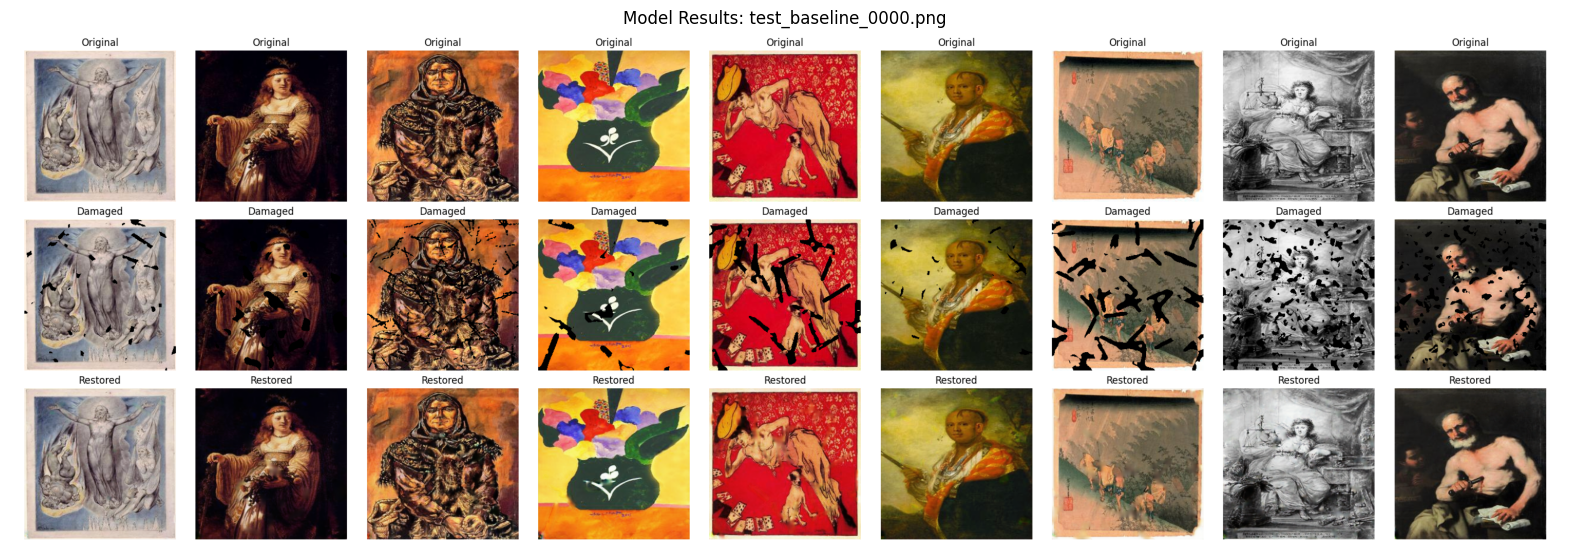


Displaying: test_maxclass_0002.png


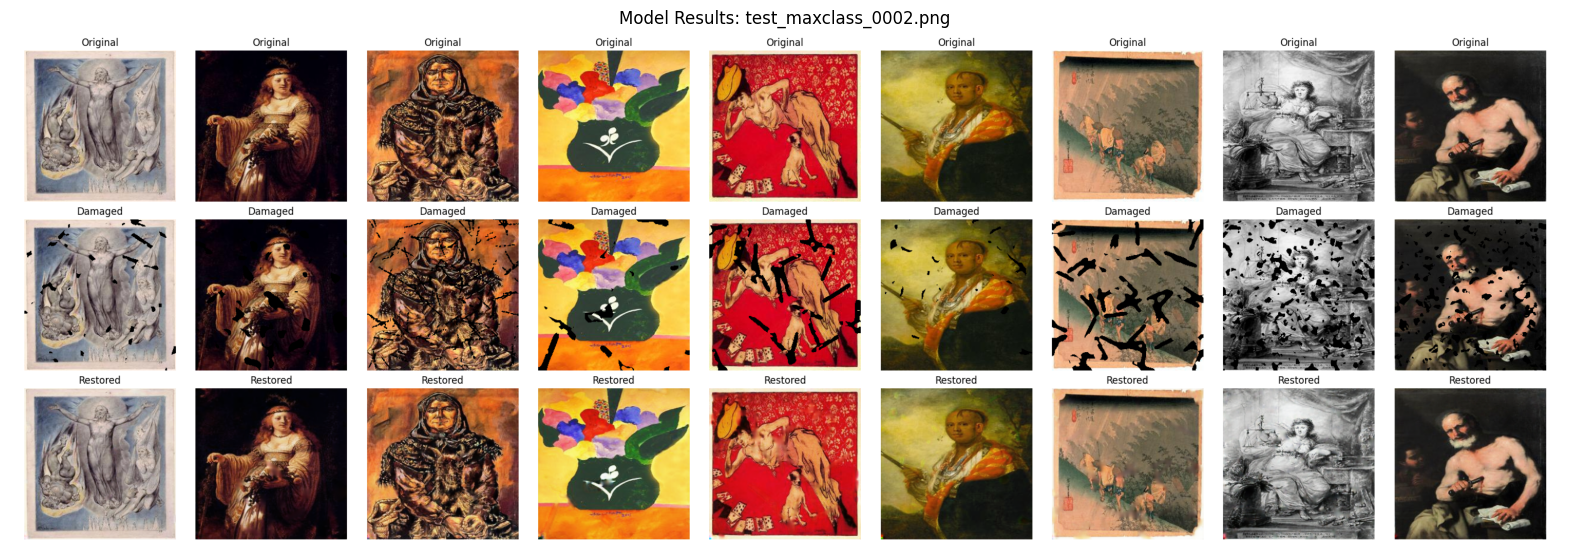


Displaying: test_real_0001.png


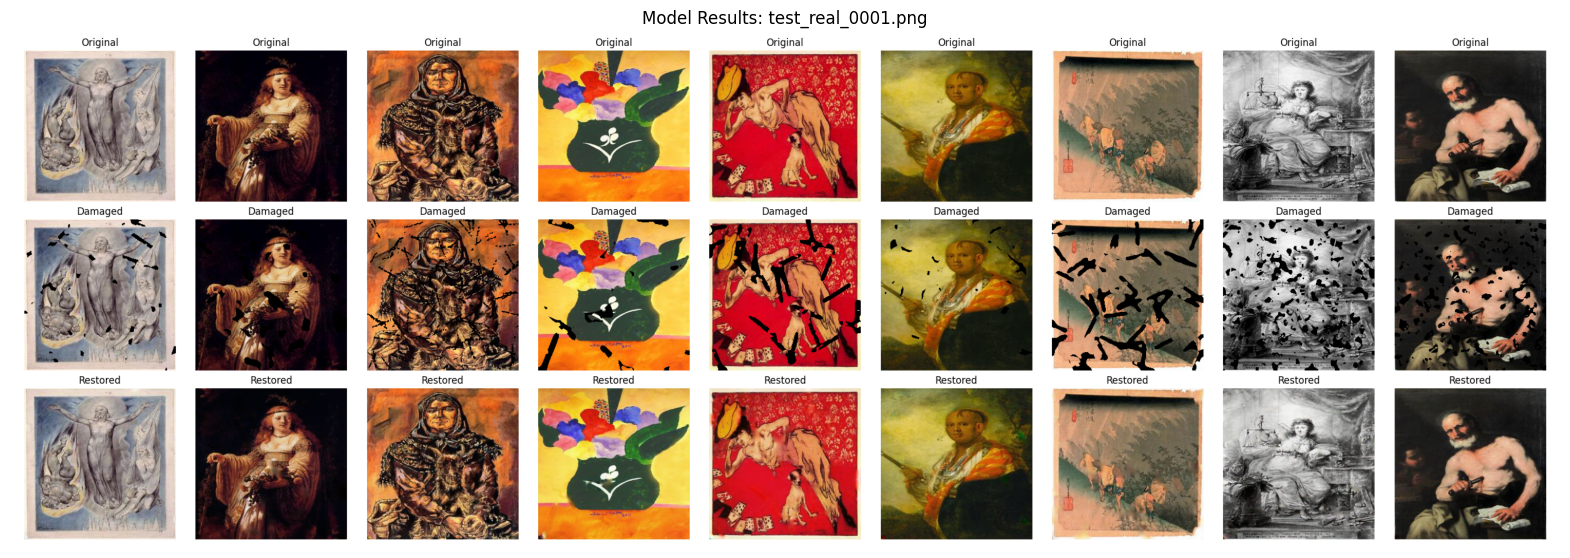

In [8]:
###################################################################
# ( 7 ) Visual Comparison (Showing imgs)
###################################################################
%matplotlib inline
import glob
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

# Find all generated visualization images in the directory
image_files = sorted(glob.glob(os.path.join(Report_file_path, "test_*.png")))

if not image_files:
    print("No images found. Check if the visualization script ran correctly.")
else:
    for img_path in image_files:
        print(f"Displaying: {os.path.basename(img_path)}")
        img = Image.open(img_path)
        
        # Using matplotlib for a nice titled display
        plt.figure(figsize=(20, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Model Results: {os.path.basename(img_path)}")
        plt.show()
        print("\n" + "="*75)

# ETAP 2: Klasteryzator

Dataset is alredy downloaded!
Uruchomione na: cuda
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce GTX 1650 Ti

Ładowanie modelu Inpainter...

Precomputed clusterizer models found. Loading...
Loaded PCA and KMeans models successfully!

Przetwarzanie danych TESTOWYCH do wizualizacji...


Przetwarzanie: 100%|█████████████████████████████████████████████████████████████████| 162/162 [05:15<00:00,  1.95s/it]


Całkowity czas przetwarzania 0 obrazów: 5.25 minut

Tworzenie wykresu dla KMeans na zbiorze testowym...


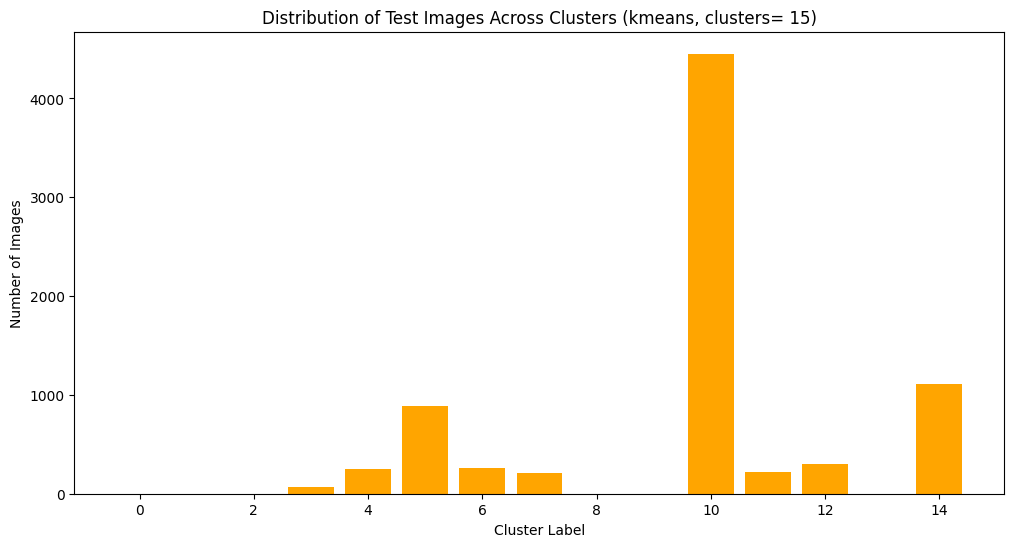

<Figure size 640x480 with 0 Axes>

In [9]:
###################################################################
# ( 1 ) Libs and Functions
###################################################################
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
from DataBase.DataBase_Functions import Custom_DataSet_Manager as DB
import torch
import torch.nn.functional as F
from InPainter.Architectures import Inpainter_V5 as Inp5
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import hdbscan
from collections import Counter
import torchvision.transforms as T
import time
from sklearn.cluster import MiniBatchKMeans
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from Config import TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT, RANDOM_STATE, RECONSTRUCTION_DATASET_PATH
from tqdm import tqdm
import gc

# Function to convert images to feature vectors using the encoder
def Image_to_vector(test_dataloader, device, encoder, batch_size):
    i = 0
    features_list = []
    start = time.time()

    # Iteracja po DataLoaderze (batches)
    for batch_images in tqdm(test_dataloader, desc="Przetwarzanie"):
        batch_images = batch_images.to(device)  # Przenieś wsad na urządzenie

        with torch.no_grad():
            features, _ = encoder(batch_images) # (B,C,H',W')

        # Global Average Pooling do (B, 128, 1, 1)
        features_pooled = F.adaptive_avg_pool2d(features, (1, 1))
        # spłaszcz do 1D (B, 128)
        features_flat = features_pooled.cpu().numpy().squeeze()

        if batch_size == 1:
            # Rozszerz features_list o cechy z całego wsadu
            features_list.append(features_flat)
        else:
            # Rozszerzenie listy o wszystkie wektory cech z wsadu
            features_list.extend(features_flat)

    time_elapsed = time.time() - start
    print(f"Całkowity czas przetwarzania {i} obrazów: {time_elapsed/60:.2f} minut")

    return features_list

#Tranformation for input images
def collate_fn_images_only(batch):
    transform = T.Compose([
        T.ToTensor(),                         # [0,1]
        T.Normalize([0.5]*3, [0.5]*3)         # [-1,1]
        ])

    images = [transform(item['image']) for item in batch]
    return torch.stack(images)

###################################################################
# ( 2 ) Preparing clusterizers if they are not present. If so then just load
###################################################################
if __name__ == '__main__':
    #Clean previous ram and gpu loads
    gc.collect()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        
    gc.collect()

    
    # Define paths
    kmeans_path = Path("Clustering/minibatch_kmeans_model.joblib")
    pca_path = Path("Clustering/pca_model.joblib")

    # Common Setup (Needed for both paths to either evaluate or plot)
    manager = DB(
        DataSet_path = RECONSTRUCTION_DATASET_PATH,
        train_split=TRAIN_SPLIT,
        val_split=VAL_SPLIT,
        test_split=TEST_SPLIT,
        random_state=RANDOM_STATE
        )

    manager.download_database("Artificio/WikiArt_Full")
    train, val, test = manager.load_dataset_from_disk()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Uruchomione na:", device)
    print("PyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

    print("\nŁadowanie modelu Inpainter...")
    checkpoint = torch.load("InPainter/models/V5_BASELINE/best_inpainter.pth", map_location=device)
    full_state = checkpoint["encoder_state_dict"]

    encoder = Inp5.Encoder(input_channels=3, base_filters=32).to(device)
    encoder_state = encoder.state_dict()
    filtered_state = {k: v for k, v in full_state.items() if k in encoder_state}
    encoder_state.update(filtered_state)
    encoder.load_state_dict(encoder_state)
    encoder.eval()

    BATCH_SIZE = 48  
    NUM_WORKERS = 0

    # Check if models exist
    if kmeans_path.is_file() and pca_path.is_file():
        print("\nPrecomputed clusterizer models found. Loading...")
        kmeans = joblib.load(kmeans_path)
        pca = joblib.load(pca_path)
        print("Loaded PCA and KMeans models successfully!")
        
        # Load TEST dataloader just for plotting
        print("\nPrzetwarzanie danych TESTOWYCH do wizualizacji...")
        plot_dataloader = DataLoader(
            dataset=test,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            collate_fn=collate_fn_images_only
        )
        
        features_list = Image_to_vector(plot_dataloader, device, encoder, BATCH_SIZE)
        X_reduced = pca.transform(features_list) # Use transform, not fit_transform
        
        labels_kmeans = kmeans.predict(X_reduced)
        counts = dict(Counter(labels_kmeans))

        print('\nTworzenie wykresu dla KMeans na zbiorze testowym...')
        X = [i for i in counts]
        Y = [i for i in counts.values()]

        plt.figure(figsize=(12, 6))
        plt.title(f"Distribution of Test Images Across Clusters (kmeans, clusters= {kmeans.n_clusters})")
        plt.xlabel("Cluster Label")
        plt.ylabel("Number of Images")
        plt.bar(X, Y, color='orange')
        plt.show()
        plt.savefig("Assets/Clustrization_test.png", dpi = 100)
        
    else:
        print("\nClusterizer models not found. Launching evaluation and training on TRAIN set...")
        
        set_len = len(train)
        
        test_dataloader = DataLoader(
            dataset=train,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            collate_fn=collate_fn_images_only
        )

        ###################################################################
        # ( 4 ) Feature extraction and clustering
        ###################################################################
        print(f"\nPrzetwarzanie {set_len} obrazów ({int(set_len/BATCH_SIZE) + 1} batchy) na wektory cech...")
        features_list = Image_to_vector(test_dataloader, device, encoder, BATCH_SIZE)
        
        #Prepartion for clustering
        pca = PCA(n_components=10)
        
        # HDBSCAN clustering
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=40,       # minimum size of clusters
            min_samples=2              # how conservative the clustering is
        )

        print("\nPrzeprowadzanie klasteryzacji HDBSCAN...")
        X_reduced = pca.fit_transform(features_list)
        labels = clusterer.fit_predict(X_reduced)   # shape (N,)
        counts = dict(Counter(labels))

        print(f'Liczba znalezionych klas: {len(counts)}')

        print('\nTworzenie wykresu dla HDBSCAN...')
        # Plotting HDBSCAN clustering results
        X = [i for i in counts]
        Y = [i for i in counts.values()]

        plt.figure(figsize=(12, 6))
        plt.title(f"Distribution of Train Images Across {len(counts)} Clusters (HDBSCAN)")
        plt.xlabel("Cluster Label")
        plt.ylabel("Number of Images")
        plt.bar(X, Y)
        plt.show()

        # MiniBatchKMeans clustering
        K = len(counts)  # K is taken from HDBSCAN results
        kmeans = MiniBatchKMeans(
            n_clusters=K,
            random_state=42,
            batch_size=32,
            n_init='auto'
        )

        labels_kmeans = kmeans.fit_predict(X_reduced)
        counts = dict(Counter(labels_kmeans))

        print('\nTworzenie wykresu dla KMeans...')
        # Plotting KMeans clustering results
        X = [i for i in counts]
        Y = [i for i in counts.values()]

        plt.figure(figsize=(12, 6))
        plt.title(f"Distribution of Train Images Across Clusters (kmeans, clusters= {K})")
        plt.xlabel("Cluster Label")
        plt.ylabel("Number of Images")
        plt.bar(X, Y, color='orange')
        plt.show()

        # Save the models using the Path objects defined at the top
        os.makedirs(kmeans_path.parent, exist_ok=True) # Ensure directory exists
        joblib.dump(kmeans, kmeans_path)
        joblib.dump(pca, pca_path)

        print(f"\nModele zostały zapisane pomyślnie!")

# ETAP KOŃCOWY: Super-Resolution  
Celem tego kroku projektu jest stworzenie modelu Super-Resolution (SR), który potrafi zwiększyć rozdzielczość obrazów dzieł sztuki (zbiór WikiArt) z zachowaniem detali malarskich (pociągnięcia pędzla, faktura płótna).

**Wykorzystane technologie:**  
- Model: SRCNN (Super-Resolution Convolutional Neural Network).  
- Dane: WikiArt (Obrazy artystyczne).  
- Środowisko: Kaggle (GPU P100/T4).  
- Śledzenie eksperymentów: Comet ML.  

**Opis modelu:**
SRCNN realizuje proces w trzech krokach:
1. **Ekstrakcja:** Warstwa 1 wyodrębnia cechy z obrazu LR.
2. **Mapowanie:** Warstwa 2 mapuje cechy na przestrzeń wysokiej rozdzielczości.
3. **Rekonstrukcja:** Warstwa 3 składa obraz końcowy HR.

**Stosowane metryki:**
* **PSNR (dB):** Podstawowa miara jakości rekonstrukcji obrazu (wyrażana w dB). Im wyższa, tym lepiej.
* **L1 Loss:** Funkcja straty używana podczas treningu. W przeciwieństwie do MSE, L1 rzadziej powoduje nadmierne "rozmycie" obrazu, co jest kluczowe przy dziełach sztuki.


## 1. Environment Setup & Dataset Management
This section initializes the project workspace and defines the core directory paths. To prevent system crashes and local storage exhaustion, the automated 100GB raw dataset download from HuggingFace has been intentionally bypassed. The pipeline assumes the use of either pre-processed local data or a pre-trained model checkpoint.

In [10]:
import os

# Define the new root directory structure
BASE_DIR = os.path.join("DataBase", "Upscaler")

DATASET_NAME = "huggan/wikiart"
RAW_DIR = os.path.join(BASE_DIR, "wikiart_hr_images")
PROCESSED_DIR = os.path.join(BASE_DIR, "wikiart_hr_512")
SPLIT_DIR = os.path.join(BASE_DIR, "data_splits_512")

# os.makedirs with exist_ok=True will automatically create all missing parent directories (DataBase and Upscaler)
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)

print(f"[INFO] Target Dataset: {DATASET_NAME}")
print("[INFO] Massive automated download has been intentionally bypassed.")
print(f"[INFO] System will rely on the pre-trained model or local data in: {PROCESSED_DIR}")

[INFO] Target Dataset: huggan/wikiart
[INFO] Massive automated download has been intentionally bypassed.
[INFO] System will rely on the pre-trained model or local data in: DataBase\Upscaler\wikiart_hr_512


## 2. Architecture & Data Handling
Here we define the core PyTorch infrastructure. The `WikiArtDataset` class manages data loading and includes an on-the-fly bicubic degradation pipeline to generate low-resolution inputs dynamically from high-resolution targets. The `SRCNN` class defines the Super-Resolution Convolutional Neural Network architecture used for the reconstruction task.

In [11]:
# ==========================================
# CELL 2: ARCHITECTURE (SRCNN & DATASET HANDLER)
# ==========================================
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset
from PIL import Image
import json
import os

class WikiArtDataset(Dataset):
    def __init__(self, json_path, img_dir):
        with open(json_path, 'r') as f:
            self.raw_paths = json.load(f)
        
        self.img_dir = img_dir
        self.hr_transform = T.Compose([T.ToTensor()])
        
        # On-the-fly degradation (LR from HR) using BICUBIC interpolation
        self.lr_transform = T.Compose([
            T.Resize((256, 256), interpolation=T.InterpolationMode.BICUBIC),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.raw_paths)

    def __getitem__(self, idx):
        windows_path = self.raw_paths[idx]
        
        # Extract filename to handle Windows-to-Linux path discrepancies
        import ntpath
        filename = ntpath.basename(windows_path)
        full_path = os.path.join(self.img_dir, filename)
        
        try:
            img = Image.open(full_path).convert('RGB')
            return self.lr_transform(img), self.hr_transform(img)
        except Exception:
            # Fallback in case of a corrupted or missing image
            return self.__getitem__((idx + 1) % len(self))

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        # Stage 0: Initial upsampling (Bicubic) to target size
        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)
        # Stage 1: Patch extraction and representation
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.relu1 = nn.ReLU(inplace=True)
        # Stage 2: Non-linear mapping
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        # Stage 3: Reconstruction
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        
    def forward(self, x):
        x = self.upsample(x) 
        out = self.relu1(self.conv1(x))
        out = self.relu2(self.conv2(out))
        out = self.conv3(out)
        return out

print("[INFO] Heavy CPU preprocessing bypassed.")
print("[INFO] Dataset Class and SRCNN Architecture initialized successfully.")

[INFO] Heavy CPU preprocessing bypassed.
[INFO] Dataset Class and SRCNN Architecture initialized successfully.


## 3. Execution Logic: Inference Fallback & Training
This block acts as the primary execution gate. To optimize compute resources, the script prioritizes loading pre-trained model weights (`srcnn_epoch_31.pth`). If the weights are absent, it verifies the presence of the local dataset before safely initiating the training loop. Training includes automatic metric logging via Comet ML and a learning rate scheduler for optimization.

In [12]:
# ==========================================
# CELL 3: EXECUTION LOGIC (LOAD VS. TRAIN)
# ==========================================
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np

# --- CONFIGURATION ---
TARGET_MODEL_PATH = "Upscaling/srcnn_epoch_31.pth"
SAVE_DIR = "Upscaling"
os.makedirs(SAVE_DIR, exist_ok=True)

BATCH_SIZE = 64 
LEARNING_RATE = 1e-4
NUM_EPOCHS = 40
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def calculate_psnr(img1, img2, border=0):
    if border > 0:
        img1 = img1[..., border:-border, border:-border]
        img2 = img2[..., border:-border, border:-border]
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    return 10 * torch.log10(1. / mse)

model = SRCNN().to(DEVICE)

# --- THE BYPASS GATE ---
if os.path.exists(TARGET_MODEL_PATH):
    print(f"[INFO] Pre-trained model found at: {TARGET_MODEL_PATH}")
    model.load_state_dict(torch.load(TARGET_MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("[SUCCESS] Model loaded and ready for inference. Training loop bypassed.")
    
else:
    print(f"[WARNING] Model not found at '{TARGET_MODEL_PATH}'. Attempting fallback to training...")
    
    TRAIN_JSON = os.path.join(SPLIT_DIR, "train_paths.json")
    VAL_JSON = os.path.join(SPLIT_DIR, "validation_paths.json")
    
    # Check if local dataset actually exists before attempting to train
    if not os.path.exists(PROCESSED_DIR) or not os.path.exists(TRAIN_JSON):
        print("\n" + "="*60)
        print("[CRITICAL ERROR] DATASET NOT FOUND!")
        print(f"-> Missing path: {PROCESSED_DIR} or JSON splits.")
        print("-> The raw dataset is ~100GB. To prevent freezing your environment, training has been safely aborted.")
        print("-> Please provide the pre-trained .pth model, or manually mount the dataset to proceed.")
        print("="*60 + "\n")
    else:
        print("[INFO] Local dataset verified. Initializing training sequence...")
        
        # Dataloaders
        train_dataset = WikiArtDataset(TRAIN_JSON, PROCESSED_DIR)
        val_dataset = WikiArtDataset(VAL_JSON, PROCESSED_DIR)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

        criterion = nn.L1Loss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scaler = torch.amp.GradScaler('cuda') 

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

        for epoch in range(NUM_EPOCHS):
            model.train()
            running_train_loss = 0.0
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
            
            for lr_imgs, hr_imgs in loop:
                lr_imgs, hr_imgs = lr_imgs.to(DEVICE), hr_imgs.to(DEVICE)
                optimizer.zero_grad()
                
                with torch.amp.autocast('cuda'):
                    outputs = model(lr_imgs)
                    loss = criterion(outputs, hr_imgs)
                
                running_train_loss += loss.item()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                loop.set_postfix(loss=loss.item())

            avg_train_loss = running_train_loss / len(train_loader)
            
            model.eval()
            val_psnr, val_loss = 0, 0  
            with torch.no_grad():
                for lr_imgs, hr_imgs in val_loader:
                    lr_imgs, hr_imgs = lr_imgs.to(DEVICE), hr_imgs.to(DEVICE)
                    outputs = model(lr_imgs)
                    loss = criterion(outputs, hr_imgs)
                    val_loss += loss.item() 
                    val_psnr += calculate_psnr(outputs, hr_imgs, border=4).item()
            
            avg_val_loss = val_loss / len(val_loader) 
            avg_val_psnr = val_psnr / len(val_loader)
            
            print(f"Epoch {epoch+1} Complete -> Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | Val PSNR: {avg_val_psnr:.2f} dB")
            scheduler.step(avg_val_loss)
            
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"srcnn_epoch_{epoch+1}.pth"))

[INFO] Pre-trained model found at: Upscaling/srcnn_epoch_31.pth
[SUCCESS] Model loaded and ready for inference. Training loop bypassed.


## 4. Inference & Progressive Upscaling
The final evaluation module. This cell applies the loaded SRCNN model to a target image, performing a progressive 4x upscale (executed mathematically in two sequential 2x passes). It outputs a Matplotlib visualization to comparatively assess the reconstruction quality against the original low-resolution input.

[INFO] Loading model from: Upscaling/srcnn_epoch_31.pth
[INFO] Initial dimensions: (256, 256)
[INFO] Step 1: Upscaling x2 (to 512x512)...
[INFO] Step 2: Upscaling x2 (to 1024x1024)...
[SUCCESS] Final dimensions: (1024, 1024)
[SUCCESS] Saved to: Assets/result_1024x1024.png


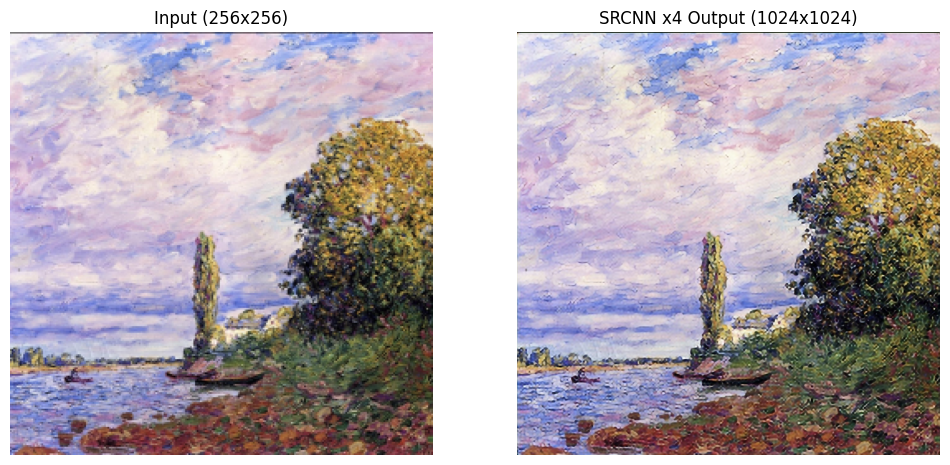

In [13]:
# ==========================================
# CELL 4: PROGRESSIVE UPSCALING (x4)
# ==========================================
import matplotlib.pyplot as plt

def upscale_x4_progressive(image_path, model_path, output_name="result_1024x1024.png"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if not os.path.exists(model_path):
        print(f"[ERROR] Cannot upscale. Model missing at: {model_path}")
        return

    print(f"[INFO] Loading model from: {model_path}")
    inference_model = SRCNN().to(device)
    inference_model.load_state_dict(torch.load(model_path, map_location=device))
    inference_model.eval()

    # Load starting image (256x256)
    img = Image.open(image_path).convert('RGB')
    transform = T.ToTensor()
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    print(f"[INFO] Initial dimensions: {img.size}")

    with torch.no_grad():
        # --- STEP 1: 256 -> 512 ---
        print("[INFO] Step 1: Upscaling x2 (to 512x512)...")
        stage1_output = inference_model(input_tensor)
        
        # Clamp values to 0-1 range to ensure valid input for Step 2
        stage1_output = stage1_output.clamp(0, 1)

        # --- STEP 2: 512 -> 1024 ---
        print("[INFO] Step 2: Upscaling x2 (to 1024x1024)...")
        final_output = inference_model(stage1_output)
        final_output = final_output.clamp(0, 1)

    # Save and visualize
    result_img = T.ToPILImage()(final_output.squeeze(0).cpu())
    result_img.save(output_name)
    print(f"[SUCCESS] Final dimensions: {result_img.size}")
    print(f"[SUCCESS] Saved to: {output_name}")

    # Visualization Comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Input ({img.size[0]}x{img.size[1]})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result_img)
    plt.title(f"SRCNN x4 Output ({result_img.size[0]}x{result_img.size[1]})")
    plt.axis('off')
    plt.show()

# --- EXECUTION ---
# Ensure you have a valid image path before running
upscale_x4_progressive("Assets/042222-256x256.png", TARGET_MODEL_PATH, output_name="Assets/result_1024x1024.png")

Podsumowanie: Model SRCNN wykazuje znaczną poprawę ostrości w porównaniu do standardowej interpolacji bicubic.